# Extended SONIC model - application to US stimuli

## Rationale
Now that we've validated our custom connection scheme, let's apply it on the same model, but upon application of US stimuli.

### Objectives
- Observe the effects of axial conduction of on the response of stimulated and non-stimulated nodes
- Characterize the fundamental differences in behavior observed by using $Q_m$ or $V_{m, eff}$ as reference voltage variable for the contribution of axial currents ???
- Assess the influence of model specification and US stimulation parameters on system behavior

### Imports
Let's import the necessary packages and modules

In [1]:
import sys
import logging
import numpy as np
import matplotlib.pyplot as plt

from PySONIC.utils import logger, si_format
from PySONIC.neurons import CorticalRS
from ExSONIC._1D import SeriesConnector, runPlotAStim

logger.setLevel(logging.DEBUG)

### Parameters
Let's set some default model and stimulation parameters.

Note that since we're trying to model the behavior of multiple "sonophore" nodes connected in series, **the default node length of the model is set to the in-plane diameter of a typical sonophore structure**.

In [2]:
# Model parameters
neuron = CorticalRS()
a = 32e-9  # sonophore diameter (m)
nnodes = 2
Ra = 1e2  # default order of magnitude found in litterature (Ohm.cm)
d = 1e-6  # order of magnitude of axon node diameter (m)
L = 1e-5  # between order of magnitude of axon node length (1 um) and internode length (100um - 1 mm)

# Stimulation parameters
Fdrive = 500e3  # Hz
Adrive = 50e3  # kPa
tstim = 150e-3  # s
toffset = 100e-3  # s
PRF = 100.  # Hz
DC = 1.

## Single-node model
Let's first check the behavior of a single node model

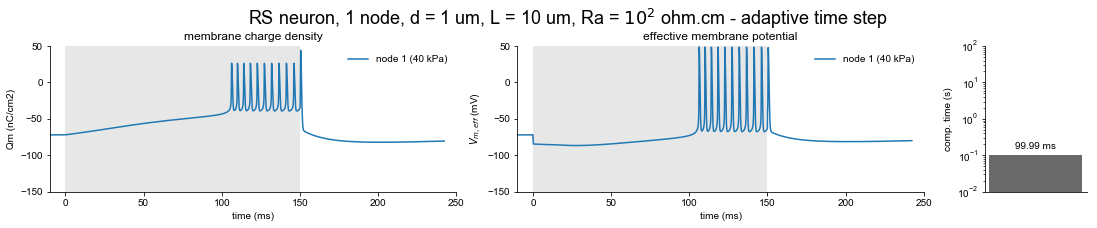

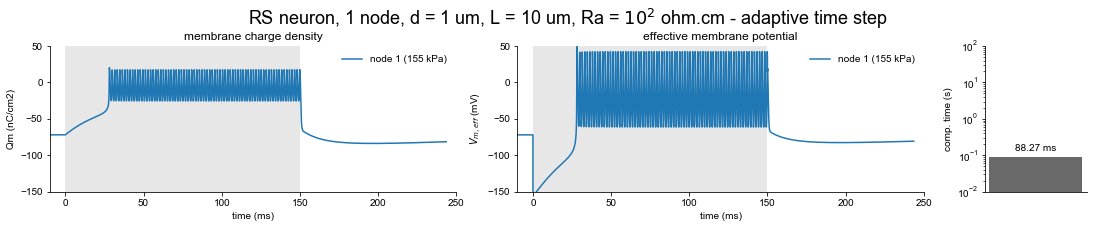

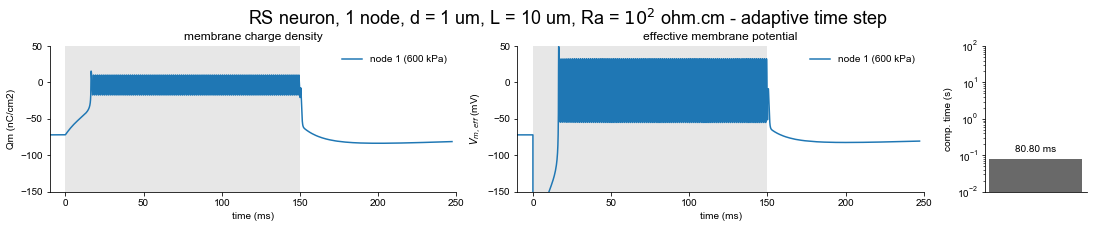

In [3]:
for Adrive_range in np.logspace(np.log10(40e3), np.log10(600e3), 3):
    fig = runPlotAStim(neuron, 1, d, L, Ra, None, a, Fdrive, Adrive_range, tstim, toffset, PRF, DC)

This single-node model behaves as expected: the US stimulus generates an instantaneous drop in effective membrane capacitance that hyperpolarizes $V_{m, eff}$ to a value far below its resting potential and then triggers a leakage-driven, progressive increase in membrane charge density up until a spiking threshold is reached, at which point the neuron starts its characteristic, US-amplitude-dependent spiking pattern.

## Extended model

Let's connect multiple nodes together with a ***SeriesConnector*** object using $V_{m, eff}$ as a reference voltage variable, with **resistance bounding enabled.**

In [4]:
# SeriesConnector object to connect sections in series through custom implementation
connector = SeriesConnector(vref='Vmeff_{}'.format(neuron.name))
print(connector)

Series connector object: Iax density mechanism, reference voltage variable = "Vmeff_RS", minimal resistance density = 2.00e+02 Ohm.cm2


### 2 nodes: default configuration

R*Am = 4.0e+00 Ohm.cm2 -> bounded to 2.0e+02 Ohm.cm2


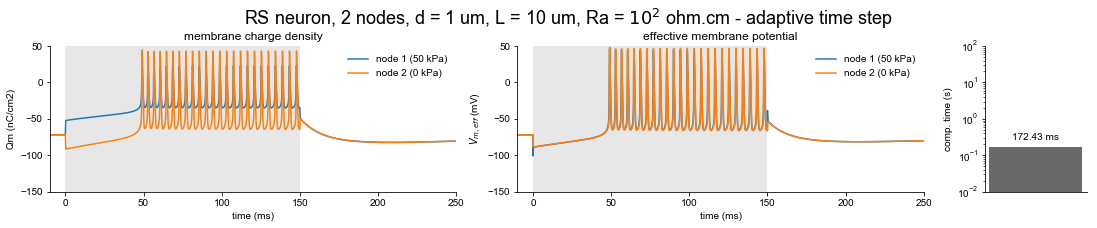

In [5]:
fig = runPlotAStim(neuron, nnodes, d, L, Ra, connector, a, Fdrive, Adrive, tstim, toffset, PRF, DC)

As we can see, in default conditions the 2 effective membrane potential profiles of the 2 nodes look perfectly identical (referred to as ***"$V_{m,eff}$-locked"***), while that of charge densities show synchronized behaviors but with different variation ranges. 

Let's analyze these profiles phase by phase:

**Phase 1 (stimulus onset):**
- stimulus onset creates an instantaneous capacitance drop and effective hyperpolarization of the stimulated node (to ca. -140 $mV$), while the non stimulated node is unaffected and stays at -70 $mV$
- $V_{m, eff}$ imbalance drives significant axial currents that equilibrate the membrane potentials of the 2 nodes almost instantaneously to an intermediate value (ca. -90 $mV$). This equilibration through axial currents drives instantaneous changes in membrane charge density (increase at the stimulated node, decrease at the neighboring node)

**Phase 2 (progressive depolarization):**
- the US stimulus progressively increases $Q_m$ and $V_{m, eff}$ at the stimulated node through leakage membrane current
- axial current spreads to the neighboring node in order to equilibrate both effective membrane potentials, which also increases $Q_m$ at the neighboring node

**Phase 3 (spiking)**:
- $Q_m$ reaches a threshold value at node 1 that drives ion channels opening and triggers a spike train
- the neighboring node also reaches its spiking threshold and opens its own ion channels to enter the spike train
- as both nodes are "$V_{m,eff}$-locked" through axial conduction, they experience exactly the same spike train in terms of effective membrane potential despite depending on different effective electrical systems (capacitance and ion channel rate constants)
- the neighboring node shows larger charge density variations since its effective electrical system is not modulated by US

**Phase 4 (stimulus offset):**
- stimulus offset instantaneously restores effective membrane capacitance of the stimulated node to its resting value
- as both nodes now have the same membrane capacitance and are "$V_{m,eff}$-locked" through axial conduction, both $Q_m$ and $V_{m, eff}$ evolve in synchrony

Note that the initial increase in $Q_m$ at the stimulated node brings the membrane much closer to its spiking threshold, which is then reached more quickly. As a result, response latency is diminished compared to a single node configuration.

## Effect of different parameters

Let's now test the effect of changes in model and stimulation parameters on the resulting behavior of the model.

### Cytoplasmic resistivity

Obviously, decreasing cytoplasmic resistivity would have no effect since both nodes are already ***"$V_{m,eff}$-locked"*** with the default value, so we will only test the influence of augmenting $R_a$.

Ra = 1e+04 Ohm.cm: R*Am = 4.0e+02 Ohm.cm2 -> not bounded
Ra = 1e+05 Ohm.cm: R*Am = 4.0e+03 Ohm.cm2 -> not bounded
Ra = 1e+06 Ohm.cm: R*Am = 4.0e+04 Ohm.cm2 -> not bounded


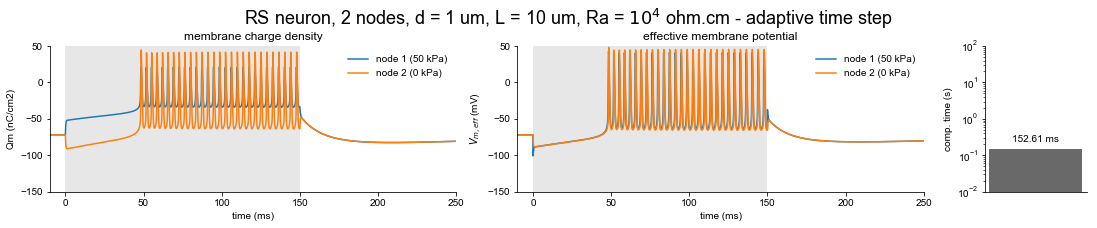

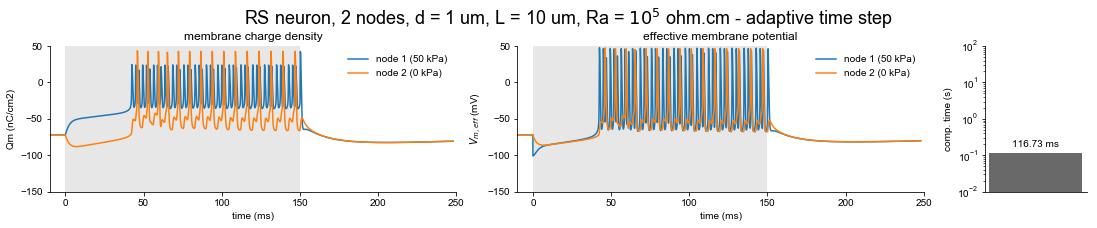

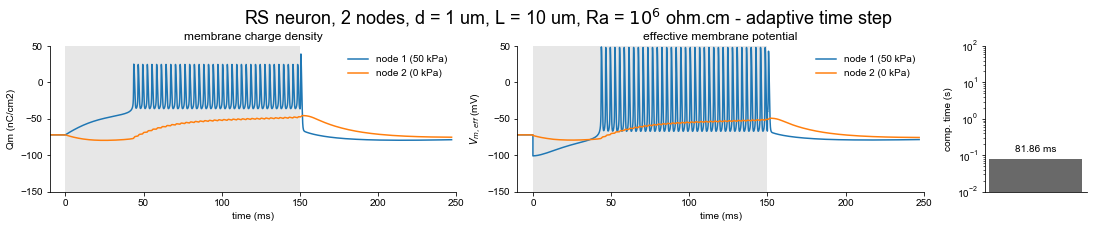

In [6]:
for Ra_range in np.logspace(4, 6, 3):
    sys.stdout.write('Ra = {:.0e} Ohm.cm: '.format(Ra_range, space=' '))
    fig = runPlotAStim(neuron, nnodes, d, L, Ra_range, connector, a, Fdrive, Adrive, tstim, toffset, PRF, DC)

As we can see, the default, "$V_{m,eff}$-locked" locked behavior of both nodes is hardly affected by cytoplasmic resistivity, since we need to increase it up to completely unrealistic values in order to restrict axial conduction down to an extent that starts decoupling effective membrane potentials ($R_a > 10^4\ \Omega \cdot cm^2$), and even higher values to stop action potential propagation completely ($R_a > 10^5\ \Omega \cdot cm^2$).

Expectedly, computation time decreases as $R_a$ increases, as a result of the reduced axial currents magnitude.

### Node diameter

Similarly as for $R_a$, augmenting node diameter would have no effect since both nodes are already ***"$V_{m,eff}$-locked"*** with the default value, so we will only test the influence of decreasing $d$.

d = 10 nm: R*Am = 4.0e+02 Ohm.cm2 -> not bounded
d = 1 nm: R*Am = 4.0e+03 Ohm.cm2 -> not bounded
d = 100 pm: R*Am = 4.0e+04 Ohm.cm2 -> not bounded


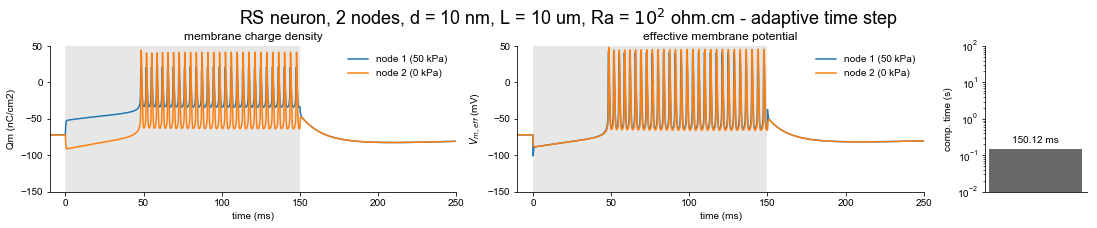

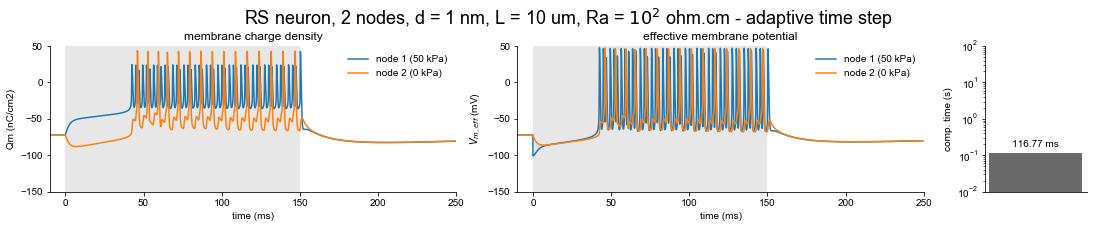

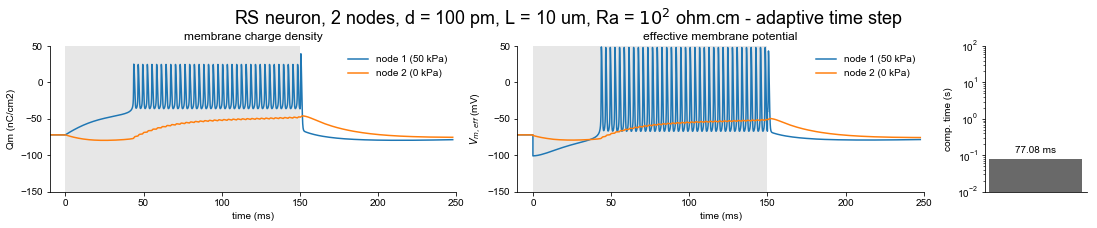

In [7]:
for d_range in np.logspace(-8, -10, 3):
    sys.stdout.write('d = {}m: '.format(si_format(d_range, space=' ')))
    fig = runPlotAStim(neuron, nnodes, d_range, L, Ra, connector, a, Fdrive, Adrive, tstim, toffset, PRF, DC)

Again, the default, "$V_{m,eff}$-locked" behavior of both nodes is hardly affected by the node diameter, since we need to decrease it down to completely unrealistic values in order to start decoupling effective membrane potentials ($d < 10\ nm$), and even lower values to stop action potential propagation completely ($d < 1< nm$).

We also observe that within their respective range of sensitivities, increasing $R_a$ or decreasing $d$ by 1 and 2 orders of magnitude yields similar changes in the distributed neural response. This makes sense if we consider that:
- distributed neural response is directly dependent on the ratio of membrane current $I_m$ vs axial current $I_{ax}$
- for the sake of simplicity, we can consider this ratio in terms of current densities ($i_m = I_m / A_m$ and $i_{ax} = I_{ax} / A_m$), since $i_m$ is constant across varying section geometries and resistivity values
- for a constant $i_m$, $i_{ax}$ is proportional to both $1/R_a$ and $d$, hence both parameters have the exact opposite effect on the distributed response.

Expectedly, computation time increases as $d$ increases, as a result of the higher axial currents magnitude.

### Node length

Similarly as for $R_a$ and $d$, diminishing node length would have no effect since both nodes are already ***"$V_{m,eff}$-locked"*** with the default value, so we will only test the influence of increasing $L$.

L = 100 um: R*Am = 4.0e+02 Ohm.cm2 -> not bounded
L = 316 um: R*Am = 4.0e+03 Ohm.cm2 -> not bounded
L = 1 mm: R*Am = 4.0e+04 Ohm.cm2 -> not bounded


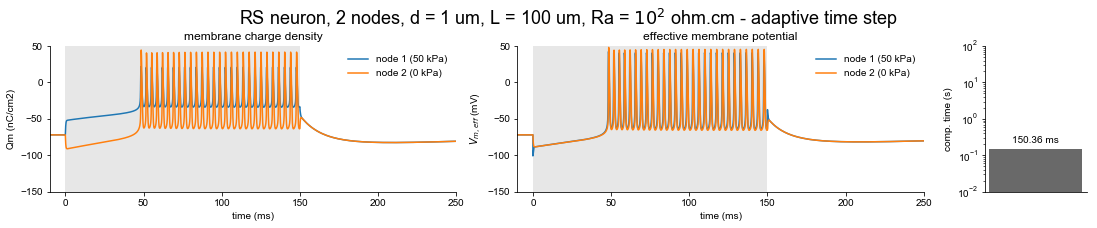

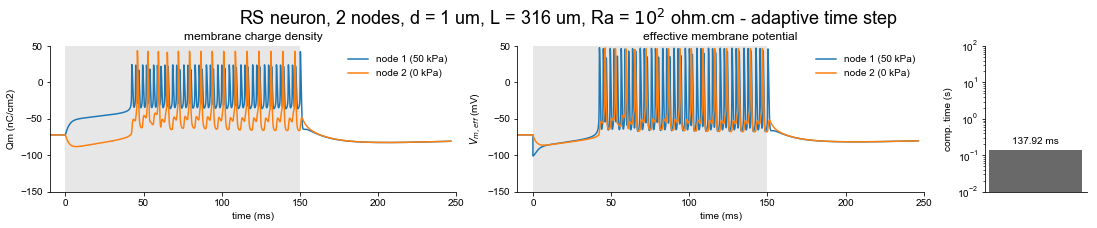

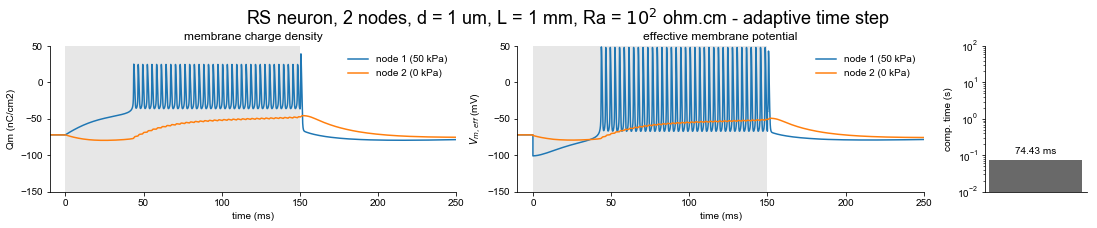

In [8]:
for L_range in np.logspace(-4, -3, 3):
    sys.stdout.write('L = {}m: '.format(si_format(L_range, space=' ')))
    fig = runPlotAStim(neuron, nnodes, d, L_range, Ra, connector, a, Fdrive, Adrive, tstim, toffset, PRF, DC)

This time, we find that **increasing node length within realistic values significantly affects the default, "$V_{m,eff}$-locked" behavior** of both nodes. In fact, increasing $L$ from $100\ \mu m$ to $1\ mm$ is enough to change the distributed neural response from complete $V_{m,eff}$ synchronization to complete decoupling (no AP propagation).

Moreover, the fact that this transition occurs only within 1 order of magnitude confirms the higher dependency of distributed neural response on node length ($i_{ax} \propto 1 / L^2$).

Expectedly, computation time decreases as $L$ increases, as a result of the reduced axial currents magnitude.

### Stimulus amplitude

Astim = 40 kPa: R*Am = 4.0e+00 Ohm.cm2 -> bounded to 2.0e+02 Ohm.cm2
Astim = 155 kPa: R*Am = 4.0e+00 Ohm.cm2 -> bounded to 2.0e+02 Ohm.cm2
Astim = 600 kPa: R*Am = 4.0e+00 Ohm.cm2 -> bounded to 2.0e+02 Ohm.cm2


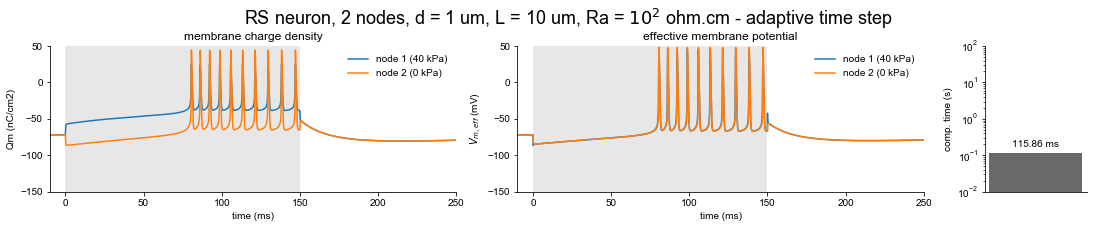

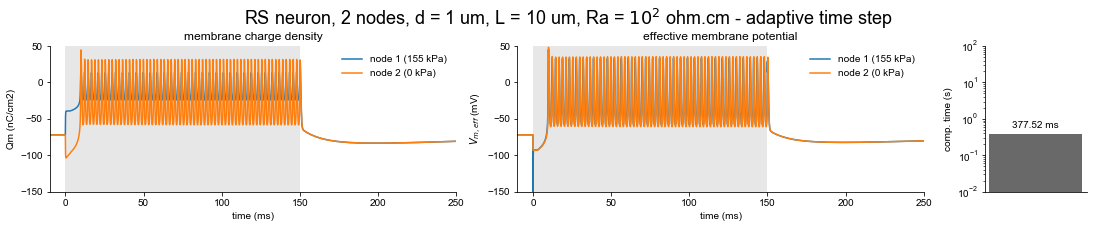

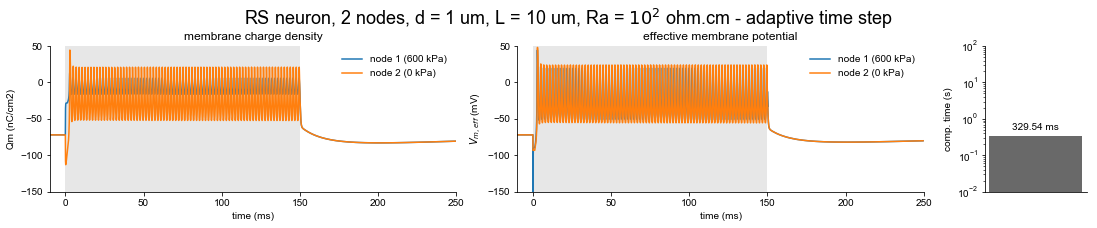

In [9]:
for Adrive_range in np.logspace(np.log10(40e3), np.log10(600e3), 3):
    sys.stdout.write('Astim = {:.0f} kPa: '.format(Adrive_range * 1e-3))
    fig = runPlotAStim(neuron, nnodes, d, L, Ra, connector, a, Fdrive, Adrive_range, tstim, toffset, PRF, DC)

Naturally, increasing the amplitude of the acoustic stimulus increases the neuron firing rate and reduces the membrane charge density variation range at the stimulated node (and to a lesser extent at the neighboring node due to $V_{m,eff}$ coupling.

Expectedly, computation time increases with the stimulus amplitude, as a result of the faster membrane dynamics.

### Stimulus duty cycle

DC = 60%: R*Am = 4.0e+00 Ohm.cm2 -> bounded to 2.0e+02 Ohm.cm2
DC = 80%: R*Am = 4.0e+00 Ohm.cm2 -> bounded to 2.0e+02 Ohm.cm2
DC = 100%: R*Am = 4.0e+00 Ohm.cm2 -> bounded to 2.0e+02 Ohm.cm2


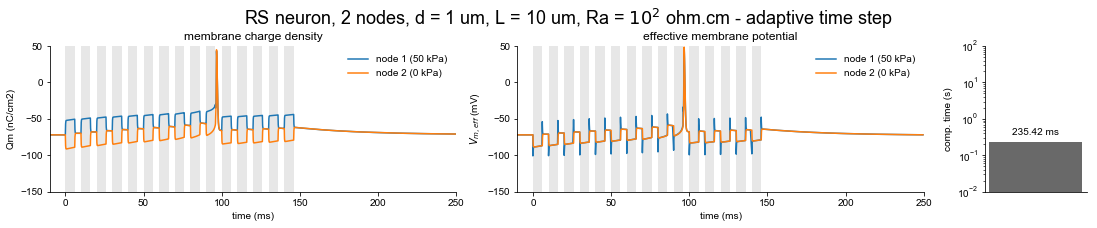

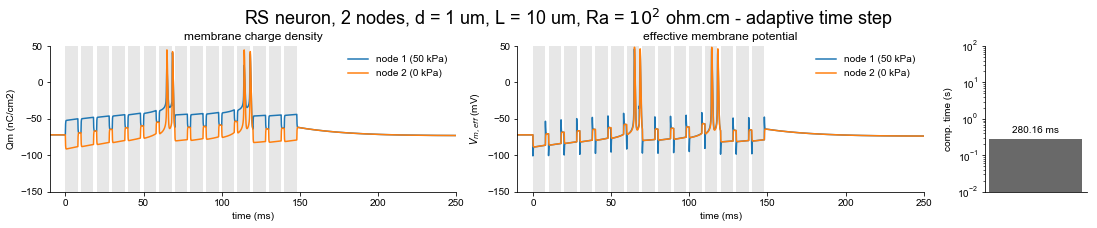

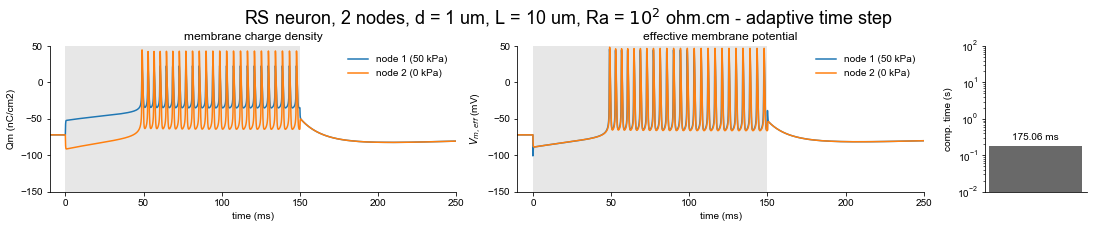

In [10]:
for DC_range in np.linspace(0.6, 1, 3):
    sys.stdout.write('DC = {:.0f}%: '.format(DC_range * 1e2))
    fig = runPlotAStim(neuron, nnodes, d, L, Ra, connector, a, Fdrive, Adrive, tstim, toffset, PRF, DC_range)

Expectedly, under pulsed stimuli, the system behaves during each pulse onset exactly as it behaves during an entire CW stimulus: 
- pulse onset triggers instantaneous capacitance drop and effective hyperpolarization at stimulated node
- effective membrane potentials equilibration through axial currents create opposite charge variations at the stimulated (> 0) and neighboring (< 0) nodes
- during US-OFF periods, membrane charge densities at both nodes evolve according to their respective electrical systems but are also slightly influenced by axial conduction that keeps both nodes "$V_{m,eff}$-locked"
- stimulus offset restores resting membrane capacitance at stimulated node, at which point both nodes evolve in synchrony during the US-OFF periods

No significant change in computation time is observed across the different conditions. 

### Number of nodes

2 nodes: R*Am = 4.0e+00 Ohm.cm2 -> bounded to 2.0e+02 Ohm.cm2
3 nodes: R*Am = 4.0e+00 Ohm.cm2 -> bounded to 2.0e+02 Ohm.cm2
6 nodes: R*Am = 4.0e+00 Ohm.cm2 -> bounded to 2.0e+02 Ohm.cm2
11 nodes: R*Am = 4.0e+00 Ohm.cm2 -> bounded to 2.0e+02 Ohm.cm2


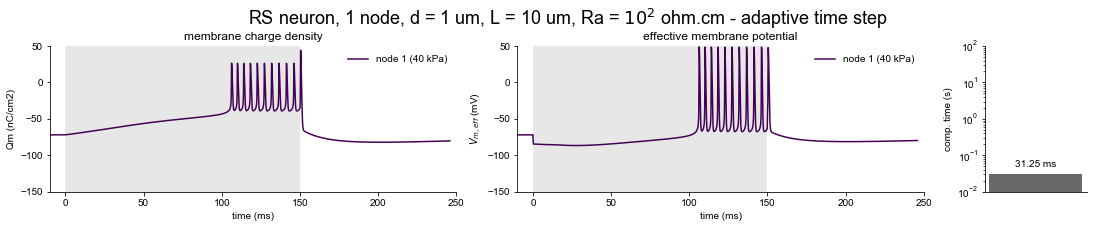

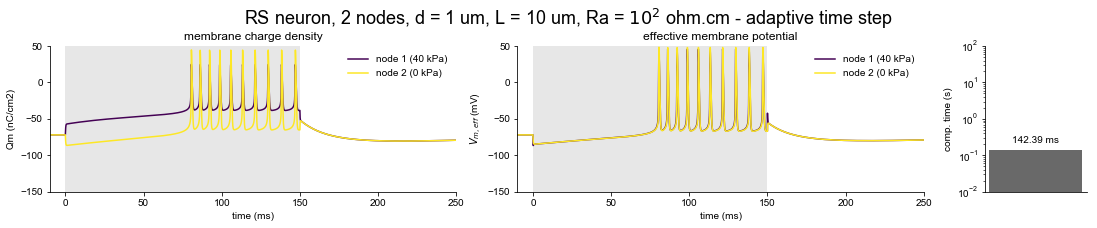

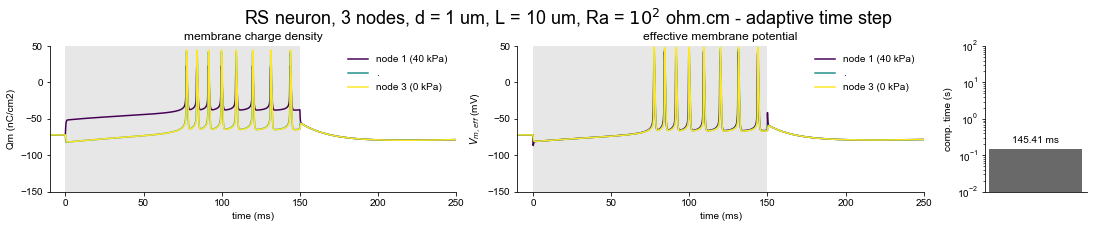

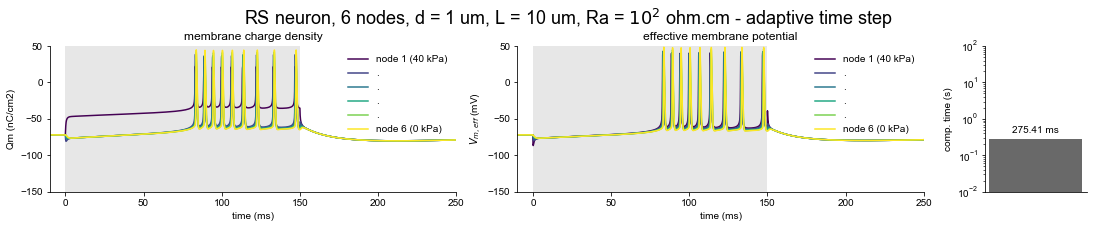

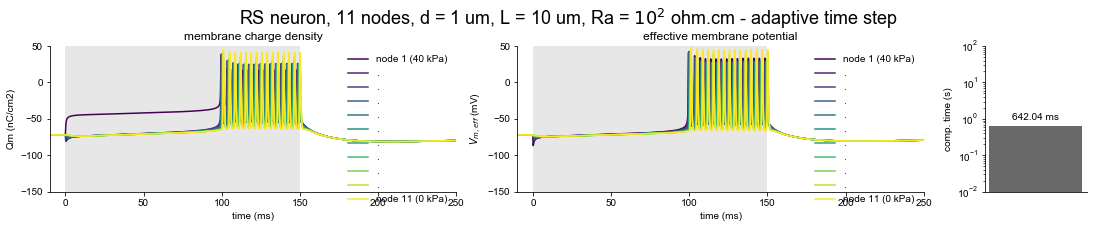

In [11]:
for nnodes_range in [1, 2, 3, 6, 11]:
    sys.stdout.write('{} nodes: '.format(nnodes_range) if nnodes_range > 1 else '')
    fig = runPlotAStim(neuron, nnodes_range, d, L, Ra, connector, a, Fdrive, 40e3, tstim, toffset, PRF, DC, cmode='seq')

Interestingly, **connecting the stimulated node with a neighboring node** does not only **decrease response latency** (for reasons explained above), but it also **decreases the firing rate**, as axial conduction effectively slows down the charge increase at the stimulated node.

**Increasing the number of nodes** creates a higher axial driving force at the stimulated node during the build-up phase: axial currents spread more intensely towards neighboring nodes, thereby hindering the depolarization of the stimulated node. As a result, the **latency starts increasing again**. Up to 4-5 nodes, the **firing rate decreases as well.**

Interestingly, if we **further increase the number of nodes**, response latency keeps increasing but the **firing rate starts increasing again** and can exceed that of a single, unconnected node.

# THE ORIGIN OF THAT TREND SHOULD BE INVESTIGATED!!!

Moreover, a slight temporal delay (a few $ms$) and increase in $V_{m, eff}$ spike amplitude (up to 10-20 $mV$) start appearing between the first and last node.

Expectedly, computation time increases with the number of nodes, as a result of the larger differential system. 

Let's now assess the effect of the number of nodes on the neuron's **excitation threshold** (determined with $kPa$ precision by a manual dichotomous search):

R*Am = 4.0e+00 Ohm.cm2 -> bounded to 2.0e+02 Ohm.cm2
R*Am = 4.0e+00 Ohm.cm2 -> bounded to 2.0e+02 Ohm.cm2
R*Am = 4.0e+00 Ohm.cm2 -> bounded to 2.0e+02 Ohm.cm2


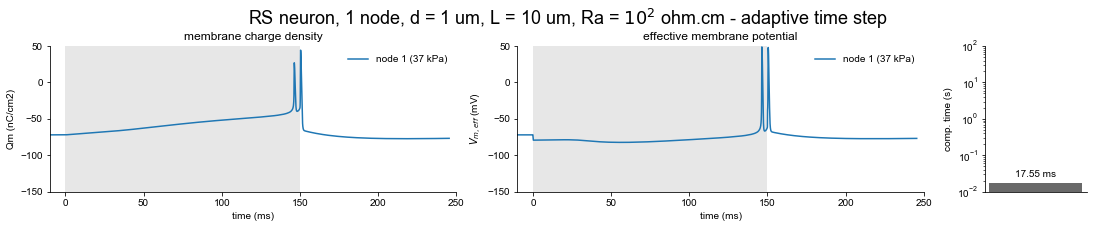

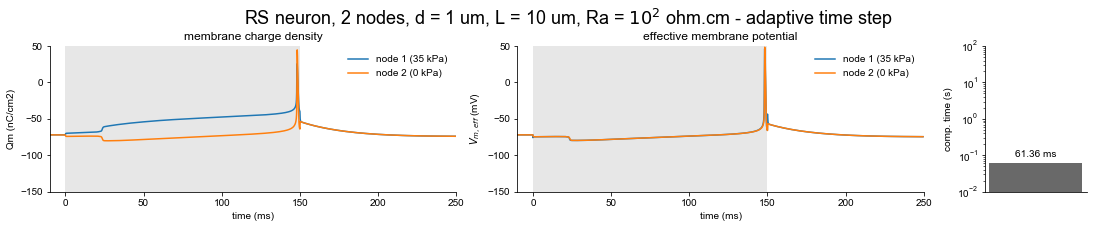

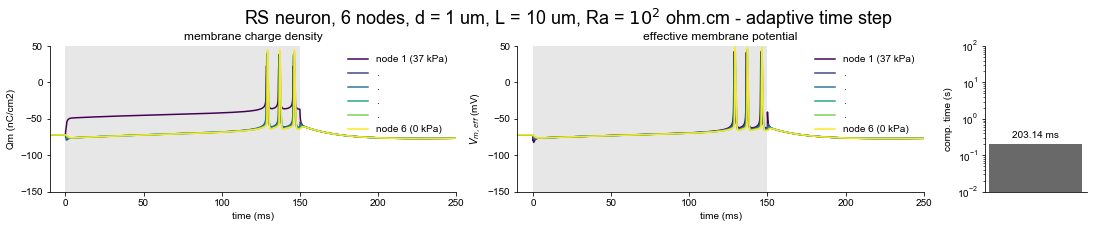

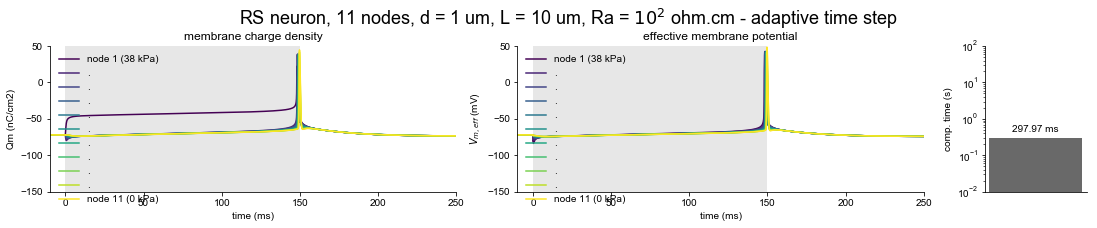

In [12]:
fig = runPlotAStim(neuron, 1, d, L, Ra, connector, a, Fdrive, 37e3, tstim, toffset, PRF, DC)
fig = runPlotAStim(neuron, 2, d, L, Ra, connector, a, Fdrive, 35e3, tstim, toffset, PRF, DC)
fig = runPlotAStim(neuron, 6, d, L, Ra, connector, a, Fdrive, 37e3, tstim, toffset, PRF, DC, cmode='seq')
fig = runPlotAStim(neuron, 11, d, L, Ra, connector, a, Fdrive, 38e3, tstim, toffset, PRF, DC, cmode='seq')

Interestingly, connecting the stimulated node to a single neighboring slightly **decreases** the excitation threshold, probably due to the initial rise in membrane charge density at stimulus onset resulting from the membrane potentials equilibration which brings $Q_m$ closer to the spiking threshold.

Remarkably, further increasing the number of nodes slightly **increases** the stimulation threshold above that of the the single-node configuration, probably because it generates a higher outward axial driving force at the stimulated node, thereby limiting its depolarization.

However, both phenomena seem to only have a very little effect on the neuron excitation threshold.

## Conclusions:
- **Custom connection scheme seems to work properly** also when dealing with a different reference voltage variable ($V_{m, eff}$).
- Connected nodes transition from a **$V_{m, eff}$-locked** state to a **completely desynchronized** state as **node length increases** within morphologically realistic bounds. 
- Connection with **a few** non-stimulated nodes arranged in series (<5) **reduces response latency and firing rate**. 
- Connection with **many** non-stimulated nodes arranged in series (>6) **reduces response latency BUT increases firing rate**. The reasons behind it should be investigated.
- Very little influence of number of nodes on excitation threshold